In [1]:
import time
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from IPython.display import Image
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class leadtime_no_negative:

    def __init__(self, Lead_scale, S, s,demands,lead_times , num_samples = 100000, SIM_TIME = 10000):


        self.SIM_TIME = SIM_TIME
        self.S = S
        self.s = s
        self.env = simpy.Environment()
        self.inventory = simpy.Container(self.env, init=self.S, capacity=self.S)
        self.last_event = 0
        self.inventory_times = defaultdict(float)
        self.fulfilled_demand = 0
        self.total_demand = 0
        self.demand_ind = 0
        self.lead_ind = 0
        self.monitor = {'last_time': 0, 'order_pending': False}
        self.last_order = 0
        self.reordertimes = []
        self.state_specific_time=defaultdict(float)
        self.end_time = SIM_TIME

        now = time.time()

        self.demands = demands
        self.lead_times = lead_times

        np.random.shuffle(self.demands)
        np.random.shuffle(self.lead_times)





        end = time.time()
        tot_time = end - now


        self.num_cust_durations = {}
        for ind in range(0, S + 1):
            self.num_cust_durations[ind] = 0

    

    def run_simulation(self,  ):

        self.env.process(self.demand_process())
        # self.env.process(self.monitor_inventory())
        self.env.process(self.snapshot_each_minute())

        self.env.run(until=self.SIM_TIME)

        # Stationary distribution
        total_time = sum(self.inventory_times.values())
        
        distribution = {k: v / total_time for k, v in self.inventory_times.items()}
        
        return distribution
    
    def snapshot_each_minute(self):
            t = int(self.env.now)  # 0
            
            self.state_specific_time[t] = self.inventory.level

            while True:
                yield self.env.timeout(1)

                t = int(self.env.now)  # 0
                if self.env.now > self.end_time:
                    break
                
                
                self.state_specific_time[t] = self.inventory.level
 
    def demand_process(self,):

        while True:


            yield self.env.timeout(self.demands[self.demand_ind % self.demands.shape[0]].item())

            self.demand_ind += 1
            self.total_demand += 1

            self.num_cust_durations[self.inventory.level] += self.env.now - self.last_event
            self.last_event = self.env.now

            if self.inventory.level > 0:
                yield self.inventory.get(1)
                self.fulfilled_demand += 1
            if self.inventory.level < self.s and not self.monitor['order_pending']:
                self.monitor['order_pending'] = True
                self.env.process(self.order_process())



    def order_process(self,):

        yield self.env.timeout(self.lead_times[self.lead_ind % self.lead_times.shape[0]])
        self.lead_ind += 1
        self.num_cust_durations[self.inventory.level] += self.env.now - self.last_event
        self.last_event = self.env.now
        yield self.inventory.put(self.S - self.inventory.level)
        reorder_time = self.env.now - self.last_order
        self.reordertimes.append(reorder_time)
        self.last_order = self.env.now
        self.monitor['order_pending'] = False

def compute_inv_dist(data, SIM_TIME):

    return np.array(list(data.values()))/SIM_TIME


def compute_pi_unfullfiled(inv_lead):

    return 1 - inv_lead.fulfilled_demand / inv_lead.total_demand


In [3]:
# S = 15 
# s = 10
# num_samples = 1000000
# SIM_TIME = 20
# Lead_scale = 1
# demands = np.random.exponential(1, 100000)
# lead_times = np.random.gamma(2,2/2,100000)

# inv_lead = leadtime_no_negative(Lead_scale ,S , s,demands,lead_times, SIM_TIME=SIM_TIME, num_samples=num_samples)

# distribution = inv_lead.run_simulation()

# data = inv_lead.num_cust_durations

# snap=inv_lead.state_specific_time


In [4]:
import numpy as np
from collections import defaultdict, Counter

# --- הגדרות הפרמטרים (בחוץ) ---
CONFIG = {
    "num_runs": 5000,
    "S": 15,
    "s": 10,
    "sim_time": 20,
    "lead_scale": 2,
    "num_samples": 1000000
}

# יצירת הדאטה מחוץ לפונקציה (מאפשר יציבות בין הרצות שונות)
demands_data = np.random.exponential(1, CONFIG["num_samples"])
lead_times_data = np.random.gamma(2, 2/2, CONFIG["num_samples"])

def run_inventory_experiment(config, demands, lead_times):
    aggregated_states = defaultdict(list)
    all_cycle_times = []
    all_stockout_probs = []
    
    for _ in range(config["num_runs"]):
        sim = leadtime_no_negative(
            Lead_scale=config["lead_scale"], 
            S=config["S"], s=config["s"], 
            demands=demands, lead_times=lead_times, 
            SIM_TIME=config["sim_time"]
        )
        sim.run_simulation()
        
        # 1. איסוף מצבי מלאי
        for t, state in sim.state_specific_time.items():
            aggregated_states[t].append(state)
            
        # 2. איסוף זמני מחזור (ממוצע לריצה)
        if sim.reordertimes:
            all_cycle_times.append(np.mean(sim.reordertimes))
            
        # 3. איסוף הסתברות לחוסר (לריצה)
        stockout_p = 1 - (sim.fulfilled_demand / sim.total_demand) if sim.total_demand > 0 else 0
        all_stockout_probs.append(stockout_p)

    # חישוב הסתברויות מלאי לפי זמן
    state_probs = {
        t: {state: count / config["num_runs"] for state, count in Counter(states).items()}
        for t, states in aggregated_states.items()
    }
    
    # החזרת מילון עם כל המדדים
    return {
        "state_probs": state_probs,
        "mean_cycle_time": np.mean(all_cycle_times) if all_cycle_times else 0,
        "stockout_prob": np.mean(all_stockout_probs)
    }
# --- הרצת הניסוי ---
result = run_inventory_experiment(CONFIG, demands_data, lead_times_data)

# הדפסת תוצאה לדוגמה
time_to_check = 1
print(f"Probabilities at time {time_to_check}: {result['state_probs'][time_to_check]}")

stockout_prob=result["stockout_prob"]
mean_cycle_time=result["mean_cycle_time"]

Probabilities at time 1: {15: 0.3794, 14: 0.3568, 12: 0.0646, 13: 0.1802, 11: 0.0162, 9: 0.0008, 10: 0.002}


In [5]:
result["stockout_prob"]

np.float64(0.0008298913686126023)

In [6]:
result["mean_cycle_time"]

np.float64(7.98162616191672)

## graphs

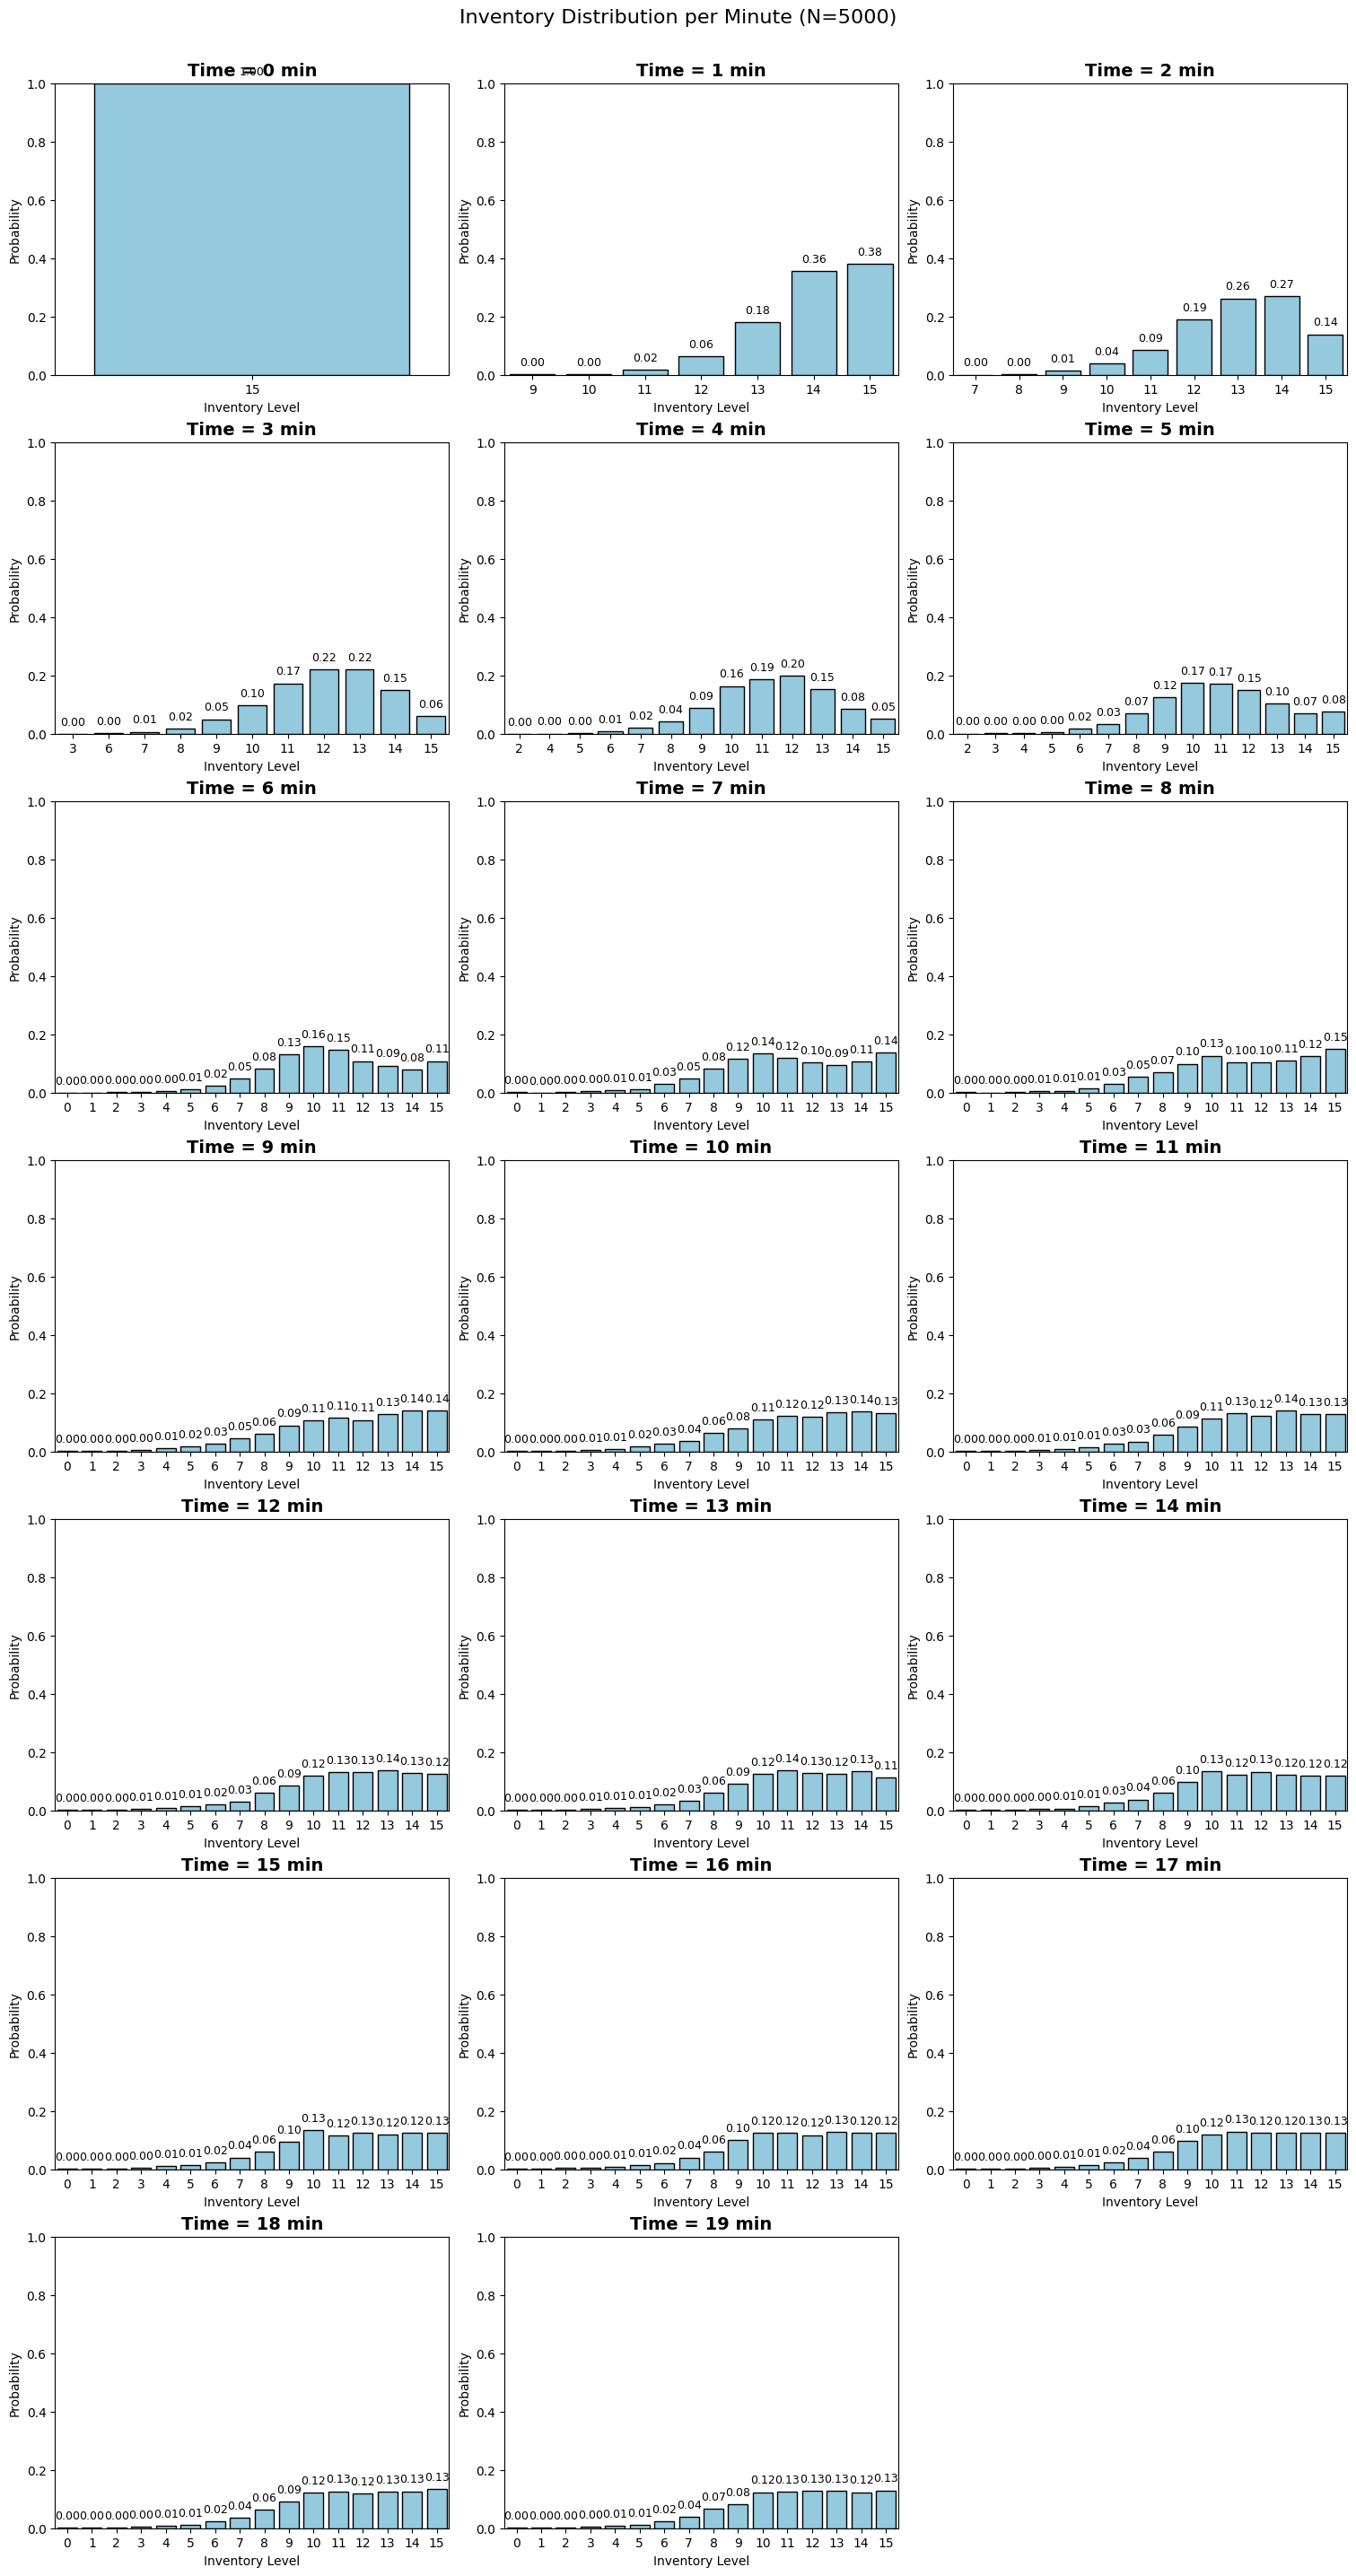

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
num_runs=CONFIG["num_runs"]
# 1. המרת הנתונים (result) ל-DataFrame נוח לעבודה
data_list = []
for t, dist in result['state_probs'].items():
    for inventory, prob in dist.items():
        data_list.append({'Time': t, 'Inventory': inventory, 'Probability': prob})

df = pd.DataFrame(data_list)

# רשימת הזמנים שיש לנו
times = sorted(df['Time'].unique())
num_plots = len(times)

# 2. חישוב גודל הגריד (כמה שורות וכמה עמודות של גרפים)
cols = 3  # מספר הגרפים בשורה (אפשר לשנות ל-2 או 4)
rows = math.ceil(num_plots / cols)

# יצירת הלוח הגדול
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
axes = axes.flatten() # משטיח את המערך כדי שיהיה קל לרוץ עליו בלולאה

# 3. לולאה שיוצרת גרף לכל דקה
for i, t in enumerate(times):
    ax = axes[i]
    
    # סינון הנתונים לאותה דקה ספציפית
    subset = df[df['Time'] == t]
    
    # ציור גרף עמודות (Barplot)
    sns.barplot(data=subset, x='Inventory', y='Probability', ax=ax, color='skyblue', edgecolor='black')
    
    # עיצוב הגרף הבודד
    ax.set_title(f"Time = {t} min", fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.0)  # מקבע את ציר Y מ-0 ל-100% כדי שיהיה קל להשוות
    ax.set_xlabel("Inventory Level")
    ax.set_ylabel("Probability")
    
    # הוספת אחוזי מעל העמודות (אופציונלי - לנוחות קריאה)
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=9, xytext=(0, 5), 
                        textcoords='offset points')

# הסתרת גרפים ריקים (אם מספר הגרפים לא מתחלק בדיוק ב-3)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Inventory Distribution per Minute (N={num_runs})", fontsize=16, y=1.02)
plt.show()

## input

#### moments

In [8]:
import numpy as np
  
def moments(val):
    # E[X^k]
    
                 # תחנות
    x =  np.array(val)
    
    powers = {}
    moments = {}

    for k in range(1, 6):  
        X_k = x**k  # moments 1..5
        # שלב 1
        powers[k] = X_k
        moments[k] = np.mean(X_k)  # שלב 2
    return moments


lead_times = moments(lead_times_data)
moments_demand=moments(demands_data)
moments_demand , lead_times

({1: np.float64(1.000430291060085),
  2: np.float64(2.000488918636805),
  3: np.float64(5.995137309127206),
  4: np.float64(23.94487916947548),
  5: np.float64(119.61717052206913)},
 {1: np.float64(2.0002600772801147),
  2: np.float64(5.9996371542434295),
  3: np.float64(23.993452179427834),
  4: np.float64(119.95308472437155),
  5: np.float64(719.6760062579244)})

## convert to tensors acoording to T 

In [9]:
import tensorflow as tf
import numpy as np
sim_time_limit = CONFIG["sim_time"]

def create_dynamic_input_tensor(S, s, lead_scale, moments_d, moments_l, t, SIM_TIME):
    # נרמול הזמן לערך בין 0 ל-1
    t_normalized = t / SIM_TIME
    
    x_values = [
        float(S), 
        float(s), 
        float(lead_scale),
        *[float(m) for m in moments_d.values()], # 5 מומנטים ביקוש
        *[float(m) for m in moments_l.values()], # 5 מומנטים אספקה
        float(t_normalized),
        
    ]
    
    return x_values # מחזיר רשימה פשוטה שנוכל לאחד למטריצה


# יצירת רשימה שתכיל את כל הוקטורים
X_list = []

for t in range(sim_time_limit):
    # הפעלת הפונקציה שיצרת
    row = create_dynamic_input_tensor(
        S=CONFIG['S'], 
        s=CONFIG['s'], 
        lead_scale=CONFIG['lead_scale'], 
        moments_d=moments_demand, # הדיקשנרי של מומנטי הביקוש
        moments_l=lead_times,     # הדיקשנרי של מומנטי ה-Lead Time
        
        t=t, 
        SIM_TIME=sim_time_limit
        )
    X_list.append(row)

# הפיכה למערך Numpy ואז לטנסור של TensorFlow
X_matrix = np.array(X_list)
X_train = tf.convert_to_tensor(X_matrix, dtype=tf.float32)

print("מבנה הטנסור (Time Steps, Features):", X_train.shape)
# תוצאה צפויה: (20, 14)

מבנה הטנסור (Time Steps, Features): (20, 14)


In [10]:
X_train[9]

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([1.5000000e+01, 1.0000000e+01, 2.0000000e+00, 1.0004303e+00,
       2.0004890e+00, 5.9951372e+00, 2.3944880e+01, 1.1961717e+02,
       2.0002601e+00, 5.9996371e+00, 2.3993452e+01, 1.1995309e+02,
       7.1967603e+02, 4.4999999e-01], dtype=float32)>

## output tensors

In [20]:
import numpy as np
import tensorflow as tf

# וידוא שהמשתנים קיימים (מתוך ה-result שקיבלנו קודם)
stockout_prob = result["stockout_prob"]
mean_cycle_time = result["mean_cycle_time"]

# הווספנו את S להגדרת הפונקציה
def convert_result_to_output(result_dict, S, stockout_prob, mean_cycle_time):
    y_output = []
    
    # מיון המפתחות לפי זמן
    sorted_times = sorted(result_dict.keys())
    
    for t in sorted_times:
        # 1. יצירת וקטור הסתברויות מלאי
        prob_vector = np.zeros(S + 1)
        for inventory_level, probability in result_dict[t].items():
            if inventory_level <= S:
                prob_vector[int(inventory_level)] = probability
        
        # 2. איחוד עם שני המדדים (תיקון שמות המשתנים כאן)
        combined_vector = np.append(prob_vector, [stockout_prob, mean_cycle_time])
        
        y_output.append(combined_vector)
    
    # המרה לטנסור
    return tf.convert_to_tensor(y_output, dtype=tf.float32)

# הפעלה מתוקנת: סדר הארגומנטים חייב להתאים להגדרה
y_train = convert_result_to_output(
    result['state_probs'], 
    CONFIG['S'], 
    stockout_prob, 
    mean_cycle_time
)

print("Output Shape:", y_train.shape) 
# יציג (10, 18) -> 10 צעדי זמן, 16 רמות מלאי + 2 מדדים

Output Shape: (20, 18)


In [21]:
import numpy as np

# 1. הוספת מימד ה-Batch ל-Input (מ-10, 14 ל-1, 10, 14)
X_final = np.expand_dims(X_train.numpy(), axis=0)

# 2. פיצול ה-Output לשני חלקים מתוך ה-y_train שיצרת
y_train_np = y_train.numpy()

# חלק א': התפלגות המלאי (אינדקסים 0 עד 15)
# אנחנו משאירים את זה כמו שהוא כי אלו כבר הסתברויות (0 עד 1)
y_dist = np.expand_dims(y_train_np[:, :CONFIG['S']+1], axis=0) 

# חלק ב': מדדי הביצועים (אינדקסים 16 ו-17)
# הערה חשובה: אנחנו מנרמלים את זמן המחזור (חלקי 100) כדי שלא "ישתלט" על הלמידה
y_metrics_raw = y_train_np[:, CONFIG['S']+1:]
y_metrics_norm = y_metrics_raw.copy()
y_metrics_norm[:, 1] = y_metrics_norm[:, 1] / 100 # נרמול זמן המחזור

y_metrics = np.expand_dims(y_metrics_norm, axis=0)

print("Batch ready!")
print(f"X shape: {X_final.shape}")      # (1, 10, 14)
print(f"Dist shape: {y_dist.shape}")    # (1, 10, 16)
print(f"Metrics shape: {y_metrics.shape}") # (1, 10, 2)

Batch ready!
X shape: (1, 20, 14)
Dist shape: (1, 20, 16)
Metrics shape: (1, 20, 2)


In [24]:
X_final.shape[2]

14

## BUILD RNN

In [13]:
# # המרת הנתונים לפורמט RNN (הוספת מימד ה-Batch)
# # X_train המקורי הוא (20, 14) -> נהפוך אותו ל (1, 20, 14)
# X_rnn = tf.expand_dims(X_train, axis=0)

# # y_train המקורי הוא (20, 16) -> נהפוך אותו ל (1, 20, 16)
# y_rnn = tf.expand_dims(y_train, axis=0)

# print(f"RNN Input Shape: {X_rnn.shape}")


In [25]:
from tensorflow.keras import layers, Model

def build_multi_head_rnn(time_steps, features, S_dim):
    # 1. שכבת קלט
    inputs = layers.Input(shape=(time_steps, features), name="main_input")
    
    # 2. שכבות LSTM משותפות (לומדות את הדינמיקה של המלאי)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    
    # --- הפיצול לראשים ---
    
    # ראש א': התפלגות המלאי (S_dim=16)
    # כאן ה-Softmax פועל רק על 16 הנוירונים האלו - זה יפתור את בעיית ה-100%
    dist_output = layers.TimeDistributed(
        layers.Dense(S_dim, activation='softmax'), name='inventory_dist'
    )(x)
    
    # ראש ב': מדדי ביצוע (Stockout & Cycle Time)
    # שימוש ב-Linear מאפשר למודל להוציא כל מספר (לא מוגבל ל-0 עד 1)
    metrics_output = layers.TimeDistributed(
        layers.Dense(y_metrics.shape[2], activation='linear'), name='performance_metrics'
    )(x)
    
    # 3. הגדרת המודל עם קלט אחד ושני פלטים
    model = Model(inputs=inputs, outputs=[dist_output, metrics_output])
    
    # 4. קומפילציה עם פונקציית הפסד שונה לכל פלט
    model.compile(
        optimizer='adam',
        loss={
            'inventory_dist': 'kl_divergence', # הכי מדויק להשוואת הסתברויות
            'performance_metrics': 'mse'       # הכי טוב לחיזוי ערכים רציפים
        },
        loss_weights={
            'inventory_dist': 1.0, 
            'performance_metrics': 0.2  # נותנים פחות משקל למדדים כדי לא "להפריע" להתפלגות
        }
    )
    
    return model

# בניית המודל לפי הממדים שלך (20 צעדי זמן, 14 מאפיינים, 16 רמות מלאי)
inventory_model = build_multi_head_rnn(time_steps=CONFIG['sim_time'], features=X_final.shape[2], S_dim=y_dist.shape[2])

In [33]:
# אימון המודל
# שימי לב שאנחנו מעבירים את ה-Y כמילון, כי הגדרנו שמות לראשים (inventory_dist ו-performance_metrics)
history = inventory_model.fit(
    X_final, 
    {
        'inventory_dist': y_dist, 
        'performance_metrics': y_metrics
    },
    epochs=5100, # נריץ 300 פעמים כדי לראות התכנסות
    verbose=0    # אפשר לשנות ל-1 כדי לראות את ההתקדמות בלייב
)

print("האימון הסתיים!")

האימון הסתיים!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


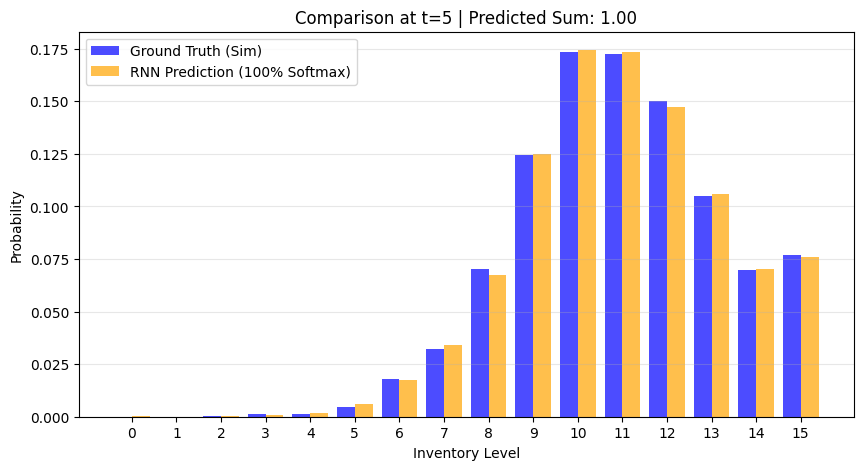

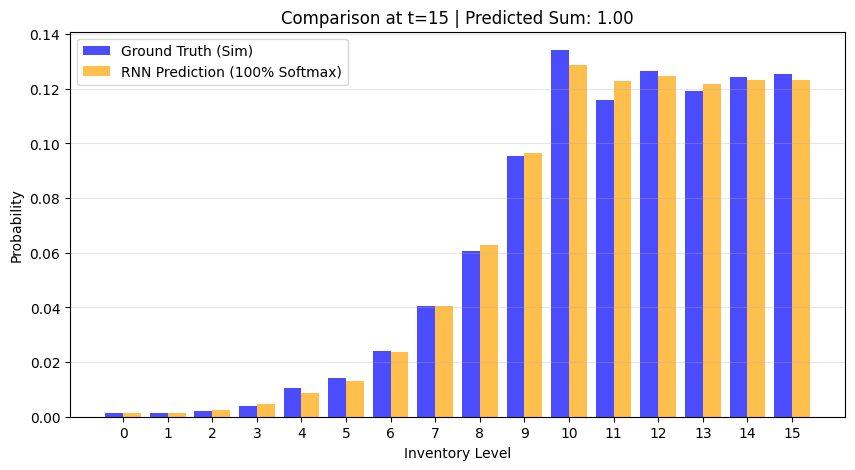

In [34]:
import matplotlib.pyplot as plt

# 1. הפקת חיזוי - המודל מחזיר רשימה של שני מערכים
predictions = inventory_model.predict(X_final)
pred_dist = predictions[0]    # התפלגות המלאי (הצהוב)
pred_metrics = predictions[1] # המדדים (זמן מחזור וחוסר)

def plot_multi_head_comparison(t_step, y_true_dist, y_pred_dist, S):
    levels = np.arange(S + 1)
    
    # שליפת הנתונים לצעד הזמן המבוקש
    true_vals = y_true_dist[0][t_step]
    pred_vals = y_pred_dist[0][t_step]
    
    plt.figure(figsize=(10, 5))
    plt.bar(levels - 0.2, true_vals, width=0.4, label='Ground Truth (Sim)', color='blue', alpha=0.7)
    plt.bar(levels + 0.2, pred_vals, width=0.4, label='RNN Prediction (100% Softmax)', color='orange', alpha=0.7)
    
    # בדיקת הסכום של הצהוב (לוודא שזה אכן 1.0)
    sum_pred = np.sum(pred_vals)
    
    plt.title(f'Comparison at t={t_step} | Predicted Sum: {sum_pred:.2f}')
    plt.xlabel('Inventory Level')
    plt.ylabel('Probability')
    plt.xticks(levels)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# בדיקה עבור צעד זמן 5 וצעד זמן 15
plot_multi_head_comparison(5, y_dist, pred_dist, S=15)
plot_multi_head_comparison(15, y_dist, pred_dist, S=15)

In [35]:
# שליפת הערכים האמיתיים והחיזויים (עבור צעד זמן מסוים, נניח האחרון)
t = 19 
true_m = y_metrics[0][t]
pred_m = pred_metrics[0][t]

# ביטול הנרמול של זמן המחזור (הכפלה ב-100)
true_cycle = true_m[1] * 100
pred_cycle = pred_m[1] * 100

# חישוב אחוז שגיאה
error_stockout = abs(pred_m[0] - true_m[0]) * 100 # בנקודות אחוז
error_cycle = abs((pred_cycle - true_cycle) / true_cycle) * 100

print(f"שגיאה בהסתברות לחוסר: {error_stockout:.2f}%")
print(f"שגיאה בזמן מחזור: {error_cycle:.2f}%")

שגיאה בהסתברות לחוסר: 0.36%
שגיאה בזמן מחזור: 1.37%


In [36]:
 # חישוב MAE עבור ההתפלגות בצעד זמן t
mae_dist = np.mean(np.abs(y_dist[0][t] - pred_dist[0][t]))
print(f"שגיאת התפלגות ממוצעת (MAE): {mae_dist:.4f}")
# אם קיבלת למשל 0.02, זה אומר שבממוצע כל עמודה טועה ב-2%

שגיאת התפלגות ממוצעת (MAE): 0.0022


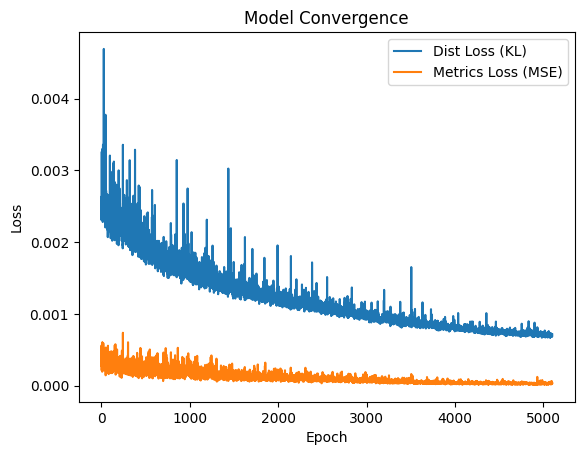

In [37]:
# ציור גרף ה-Loss לאורך האימון
plt.plot(history.history['inventory_dist_loss'], label='Dist Loss (KL)')
plt.plot(history.history['performance_metrics_loss'], label='Metrics Loss (MSE)')
plt.title('Model Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Starting to generate 20 samples...
Generated 5/20 samples
Generated 10/20 samples
Generated 15/20 samples
Generated 20/20 samples

Dataset ready!
Final X Shape: (20, 20, 14)


In [39]:
# בניית המודל עבור MAX_S
inventory_model_general = build_multi_head_rnn(
    time_steps=CONFIG['sim_time'], 
    features=X_train_final.shape[2], 
    S_dim=MAX_S + 1
)

# אימון על כל הדאטה-סט
history = inventory_model_general.fit(
    X_train_final,
    {
        'inventory_dist': y_dist_final, 
        'performance_metrics': y_metrics_final
    },
    epochs=150,
    batch_size=4, # מעבדים 4 שילובי מדיניות בכל פעם
    verbose=1
)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - inventory_dist_loss: 1.1663 - loss: 1.1772 - performance_metrics_loss: 0.0544
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 1.1030 - loss: 1.1071 - performance_metrics_loss: 0.0202 
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - inventory_dist_loss: 1.0635 - loss: 1.0669 - performance_metrics_loss: 0.0168 
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - inventory_dist_loss: 1.0276 - loss: 1.0293 - performance_metrics_loss: 0.0083 
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - inventory_dist_loss: 1.0002 - loss: 1.0011 - performance_metrics_loss: 0.0047 
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.9678 - loss: 0.9692 - performance_metrics_loss: 0.0070 
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.9375 - loss: 0.9389 - performance_metrics_loss: 0.0070 
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.9084 - loss: 0.90

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - inventory_dist_loss: 1.1298 - loss: 1.1453 - performance_metrics_loss: 0.0776
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 1.0637 - loss: 1.0659 - performance_metrics_loss: 0.0109 
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - inventory_dist_loss: 1.0247 - loss: 1.0265 - performance_metrics_loss: 0.0090 
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.9852 - loss: 0.9873 - performance_metrics_loss: 0.0102 
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.9538 - loss: 0.9551 - performance_metrics_loss: 0.0066 
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - inventory_dist_loss: 0.9221 - loss: 0.9231 - performance_metrics_loss: 0.0055 
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.8987 - loss: 0.8997 - performance_metrics_loss: 0.0051 
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - inventory_dist_loss: 0.8706 - loss: 0.87

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


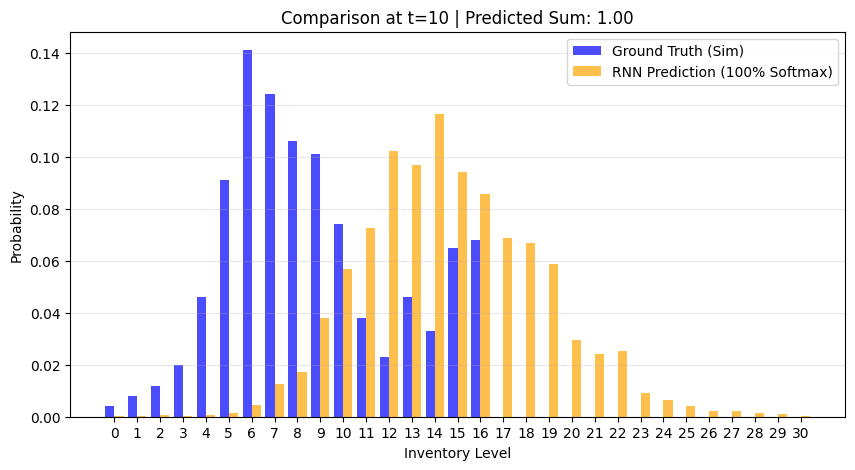

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


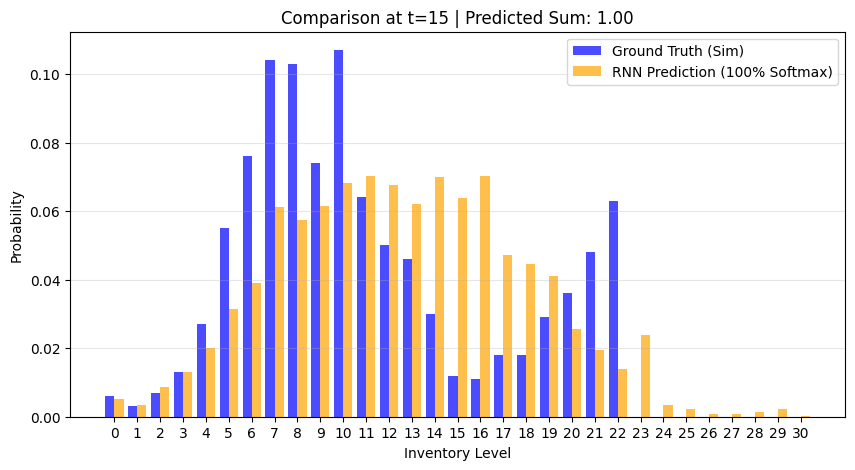

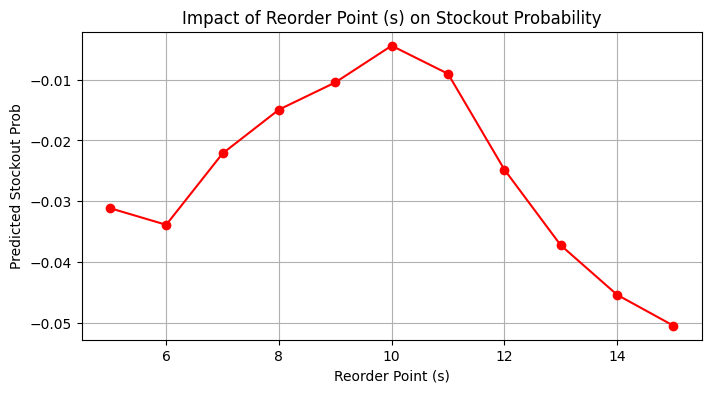